# Example Growth Charts

Work to show the possible examples.

Two main dictionaries are created:

1. DDStats, indexed as a function of calendar day
2. GStats, indexed as a function of team games played

For the future, apply the boolean mask to make
3. BStats, indexed as a function of potential games played

In [5]:
# give python3 compatibility
from __future__ import print_function

In [6]:
# boilerplate imports

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

import time

import matplotlib as mpl

import datetime


In [7]:
#
# read in all the data
#
f = open('data/gamelogs.dat')


zero_day = 75
max_day = 300


DDStats = {}

for line in f:
    q = [d.strip(" ") for d in line.split(';')]
    
    if q[0] not in DDStats.keys():
        DDStats[q[0]] = {}
        
    if q[1] not in DDStats[q[0]].keys():
        
        if q[0] in ['OPP','POS','TEAM']:
            DDStats[q[0]][q[1]] = np.zeros(max_day-zero_day,dtype='S5')
            
        else:
            DDStats[q[0]][q[1]] = np.zeros(max_day-zero_day)
        
    for indx in range(0,len(q)-3):
        #print(q[0],q[1],q[indx+2])
        
        if q[0] in ['OPP','POS','TEAM']:
            DDStats[q[0]][q[1]][indx] = q[indx+2]

        else:
            try:
                DDStats[q[0]][q[1]][indx] = float(q[indx+2])
            except:
                DDStats[q[0]][q[1]][indx] = 0.
    


f.close()

print('Available data keys:')
print(DDStats.keys())

Available data keys:
['OPP', 'BB', 'HR', 'H', 'BO', 'POS', 'PA', 'SO', 'RBI', 'TEAM', 'SB', 'R']


In [8]:

#
# read in team game data
#
f = open('data/teamgames.dat','r')

GGDict = {}
for line in f:
    q = [d for d in line.split()]
    GGDict[q[0]] = np.array(q[1:]).astype('int')
    
f.close()


#
# and helper items for translating
#


team_translate = {'angels':'LAA','astros':'HOU','athletics':'OAK',\
                  'bluejays':'TOR','braves':'ATL','brewers':'MIL',\
                  'cardinals':'STL','cubs':'CHC','diamondbacks':'ARI',\
                  'dodgers':'LAD','giants':'SFG','indians':'CLE',\
                  'mariners':'SEA','marlins':'MIA','mets':'NYM',\
                  'nationals':'WSN','orioles':'BAL','padres':'SDP',\
                  'phillies':'PHI','pirates':'PIT','rangers':'TEX',\
                  'rays':'TBR','reds':'CIN','redsox':'BOS',\
                  'rockies':'COL','royals':'KCR','tigers':'DET',\
                  'twins':'MIN','whitesox':'CHW','yankees':'NYY'}


def translate_team(team_translate,inteam):
    
    try:
    
        return np.array(team_translate.keys())[np.where(inteam==np.array(team_translate.values()))[0]][0]

    except:
        
        return ''

    
def generate_schedule(GGDict,team,min_day=75,max_day=300):
    
    schedule = []
    
    for i in range(min_day,max_day):
        
        if i in GGDict[team]:
            schedule.append(team)
            
        else:
            schedule.append('')

    return np.array(schedule)






In [11]:
# reorganize with game numbers(e.g. including days the team played and they sat)

zero_day = 75
max_day = 300

GStats = {}

for key1 in np.array(DDStats.keys()):
    
    GStats[key1] = {}
    
    for key2 in np.array(DDStats[key1].keys()):
        
        if key1 in ['OPP','POS','TEAM']:
            GStats[key1][key2] = np.zeros(max_day-zero_day+50,dtype='S5')
            
        else:
            GStats[key1][key2] = np.zeros(max_day-zero_day+50) + np.nan
            
        gnum = 0
        for indx,val in enumerate(DDStats[key1][key2]):
            
            #print(indx,val.strip('@'))
            
            if DDStats['POS'][key2][indx] != '':
                GStats[key1][key2][gnum] = DDStats[key1][key2][indx]
                gnum += 1
                
            else:
                # identify which team (forward-looking)
                indx1 = 0
                while (DDStats['TEAM'][key2][indx+indx1] == '') & (indx1 < 3) & (indx < 210):
                    #print(indx,key2)
                    indx1 += 1
                    
                if indx1 == 10:
                    pass
                    #print('last game')
                    
                which_team = (DDStats['TEAM'][key2][indx+indx1]).strip('@')
                
                # check if team had a game
                if which_team != '':
                    if (indx+zero_day) in GGDict[translate_team(team_translate,which_team)]:
                        #print('off day')
                        GStats[key1][key2][gnum] = GStats[key1][key2][gnum-1]
                        gnum += 1
                
        #print(key2,gnum)



### Open Questions

1. How to treat DL?
2. How to treat off days?

### Desired Functionality

1. By batting order
2. By position
3. By age
4. By opponent?

956


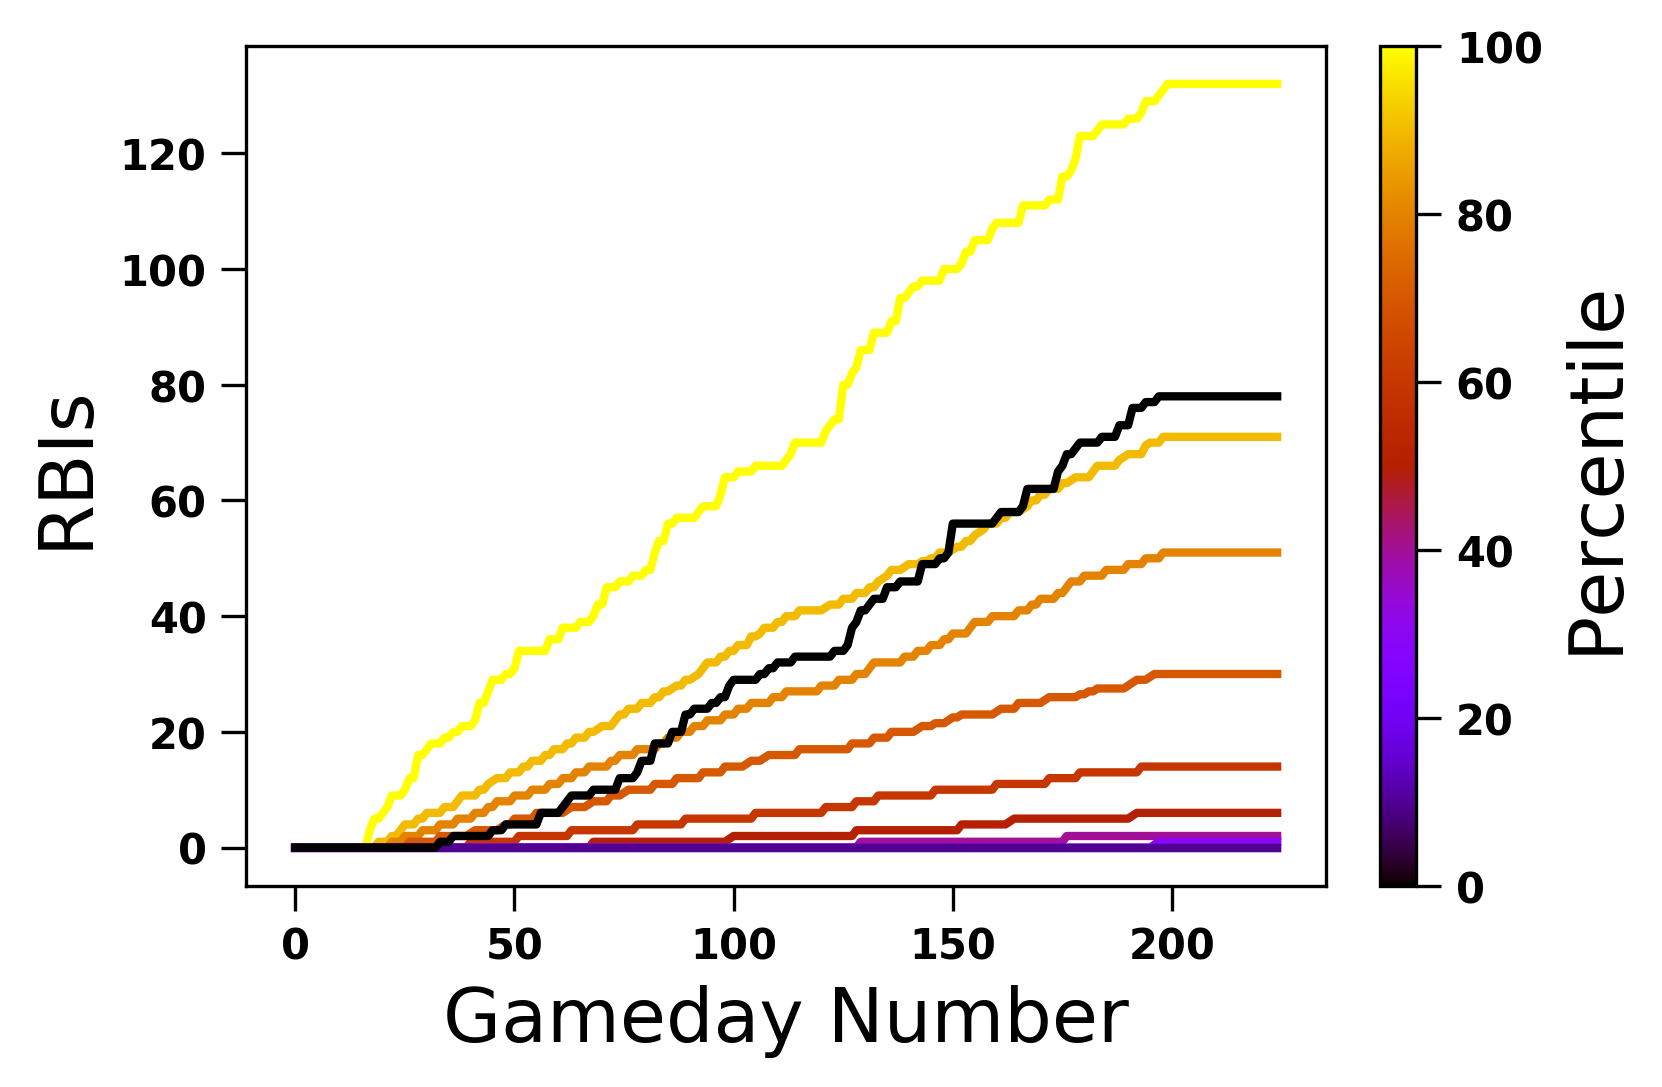

In [9]:
#
# Example 1: RBI across the league (no PA cuts), with Whit imposed
#

PAlist = np.zeros([len(np.array(DDStats['PA'].keys())),max_day-zero_day])


stat = 'RBI'
print(len(np.array(DDStats[stat].keys())) )

for indx,player in enumerate(DDStats[stat].keys()):
    PAlist[indx] = np.cumsum(DDStats[stat][player])


fig = plt.figure()
ax = fig.add_axes([0.18,0.22,0.6,0.7])
ax2 = fig.add_axes([0.81,0.22,0.02,0.7])

    
    
for perc in range(100,0,-10):
    ax.plot(np.percentile(PAlist,perc,axis=0),color=cm.gnuplot(float(perc/100.),1.))
    

ax.plot(np.cumsum(DDStats[stat]['Whit Merrifield']),color='black')

    
ax.set_ylabel('RBIs',size=18)
ax.set_xlabel('Gameday Number',size=18)
    
cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=0, vmax=100)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Percentile',size=18)





(array([ 0,  3,  4,  7, 10, 12, 13, 14, 24, 25, 26, 27, 28, 29, 30, 33, 34,
       35, 36, 38]),)


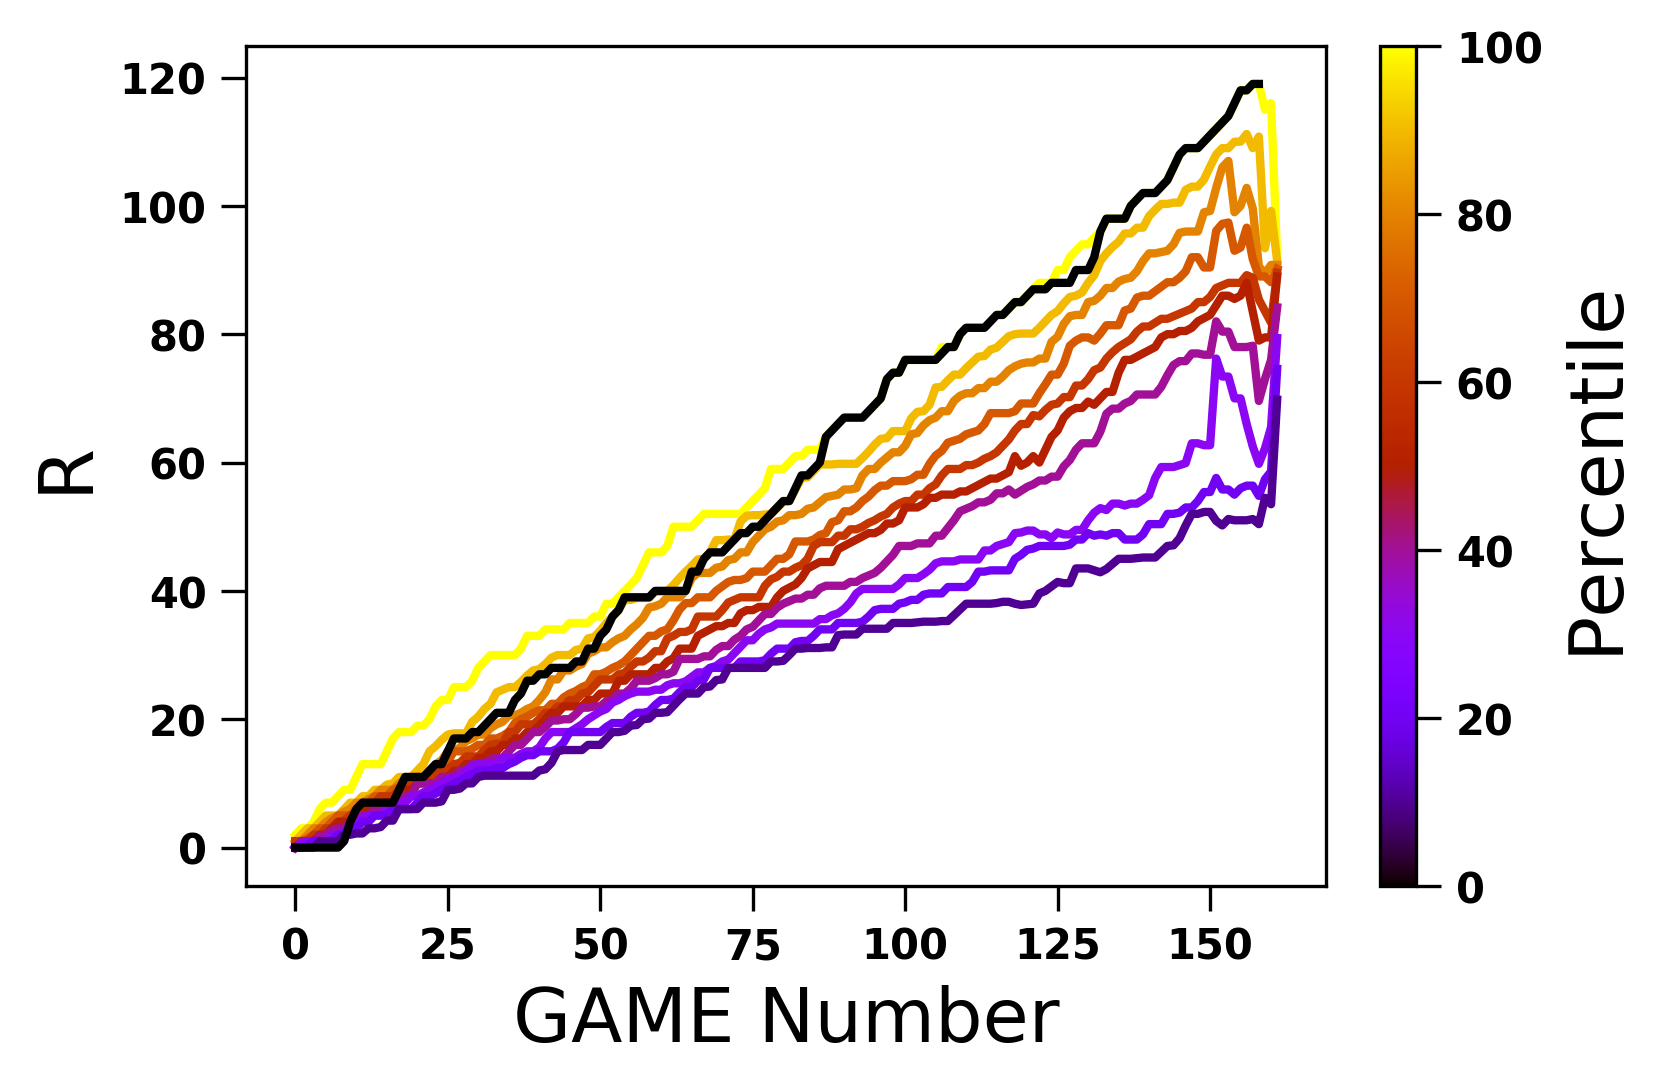

In [18]:
#
# Example 2: runs for second basemen who started >50 games, sorted by game numbers
#    with Jose Altuve plotted over the top

buff = 50
des_pos = '2B'
plist = []

for indx,plr in enumerate(DDStats['POS'].keys()):
    if len(np.where(GStats['POS'][plr] == des_pos)[0]) > 50:
        plist.append(plr)
        

PAlist = np.zeros([len(plist),max_day-zero_day+buff])



stat = 'R'
#print(len(np.array(DDStats[stat].keys())) )

#for indx,player in enumerate(DDStats[stat].keys()):
for indx,player in enumerate(np.array(plist)):
    
    PAlist[indx] = np.cumsum(GStats[stat][player])


fig = plt.figure()
ax = fig.add_axes([0.18,0.22,0.6,0.7])
ax2 = fig.add_axes([0.81,0.22,0.02,0.7])

    
    
for perc in range(100,0,-10):
    ax.plot(np.nanpercentile(PAlist,perc,axis=0),color=cm.gnuplot(float(perc/100.),1.))
    

ax.plot(np.cumsum(GStats[stat]['Jose Altuve']),color='black')

    
ax.set_ylabel(stat,size=18)
ax.set_xlabel('GAME Number',size=18)
    
cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=0, vmax=100)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Percentile',size=18)


print(np.where(PAlist[:,150] >= 0.))


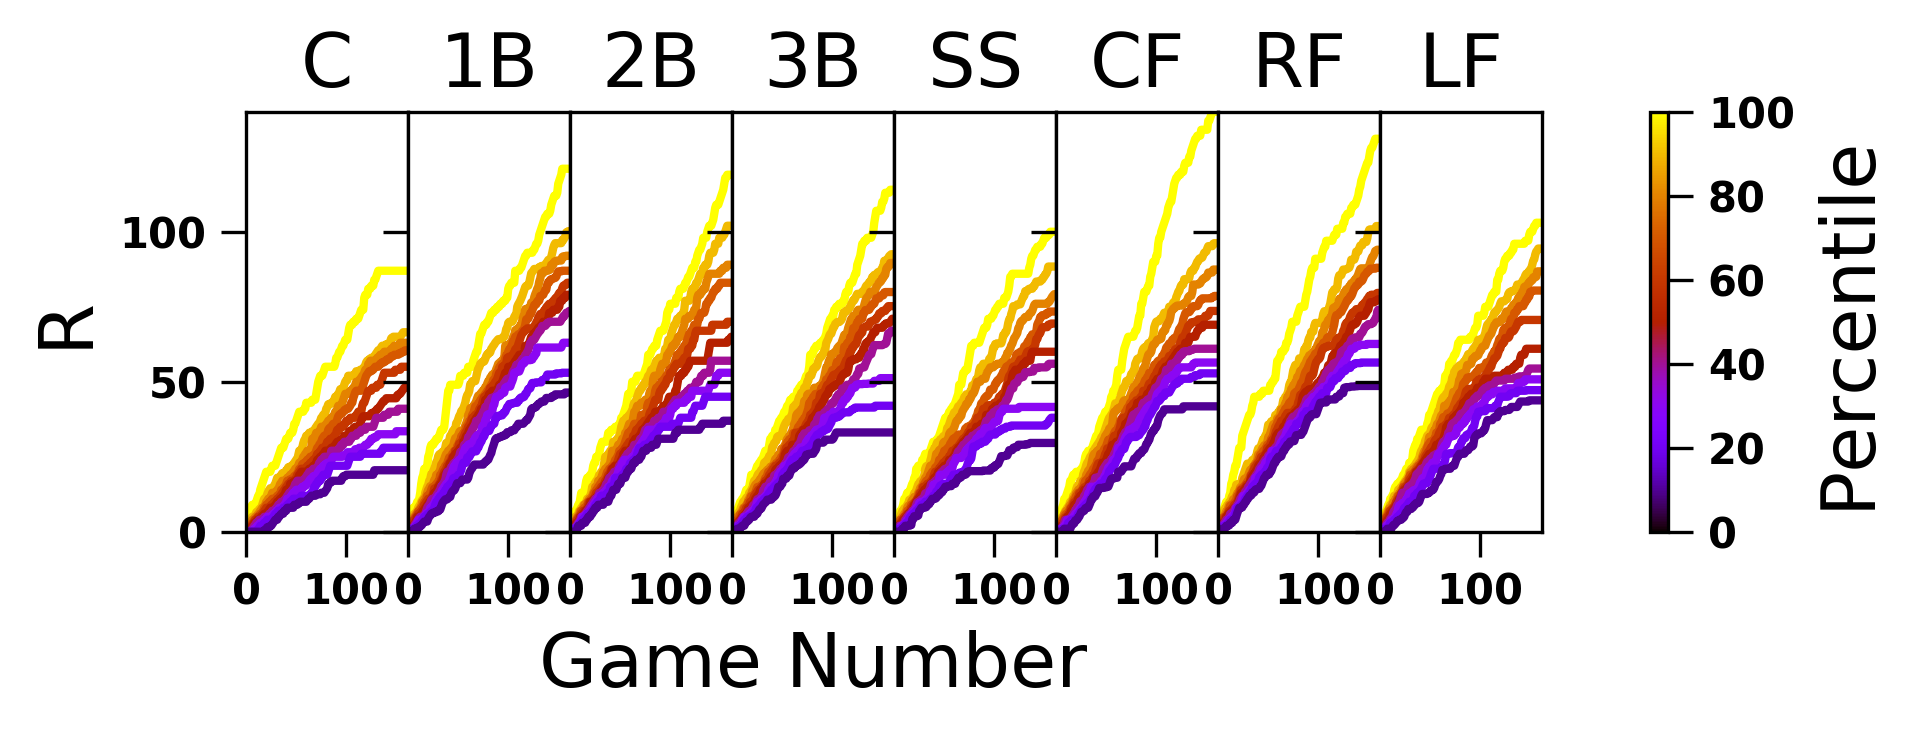

In [21]:
#
# Example 3: several positions, plotting R
#
fig = plt.figure(figsize=(6,2))

for indx1,des_pos in enumerate(np.array(['C','1B','2B','3B','SS','CF','RF','LF'])):
    
    ax = fig.add_axes([0.12+(indx1*(0.75-.12)/7.),0.22,(0.75-.12)/7.,0.7])


    plist = []

    for indx,plr in enumerate(GStats['POS'].keys()):
        
        try:
            if len(np.where(GStats['POS'][plr] == des_pos)[0]) > 50:
                plist.append(plr)
        except:
            pass


    PAlist = np.zeros([len(plist),max_day-zero_day+buff])


    stat = 'R'

    for indx,player in enumerate(np.array(plist)):

        PAlist[indx] = np.nancumsum(GStats[stat][player])


    for perc in range(100,0,-10):
        ax.plot(np.percentile(PAlist,perc,axis=0),color=cm.gnuplot(float(perc/100.),1.))


    if indx1==0: 
        ax.set_ylabel(stat,size=18)
    else:
        ax.set_yticklabels(())
        
    if indx1==3: ax.set_xlabel('Game Number',size=18)
    ax.set_title(des_pos,size=18)

    ax.axis([0.0,162.,0.,140.])
    

ax2 = fig.add_axes([0.90,0.22,0.01,0.7])


cmap = mpl.cm.gnuplot; norm = mpl.colors.Normalize(vmin=0, vmax=100)
cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,norm=norm)
cb1.set_label('Percentile',size=18)



